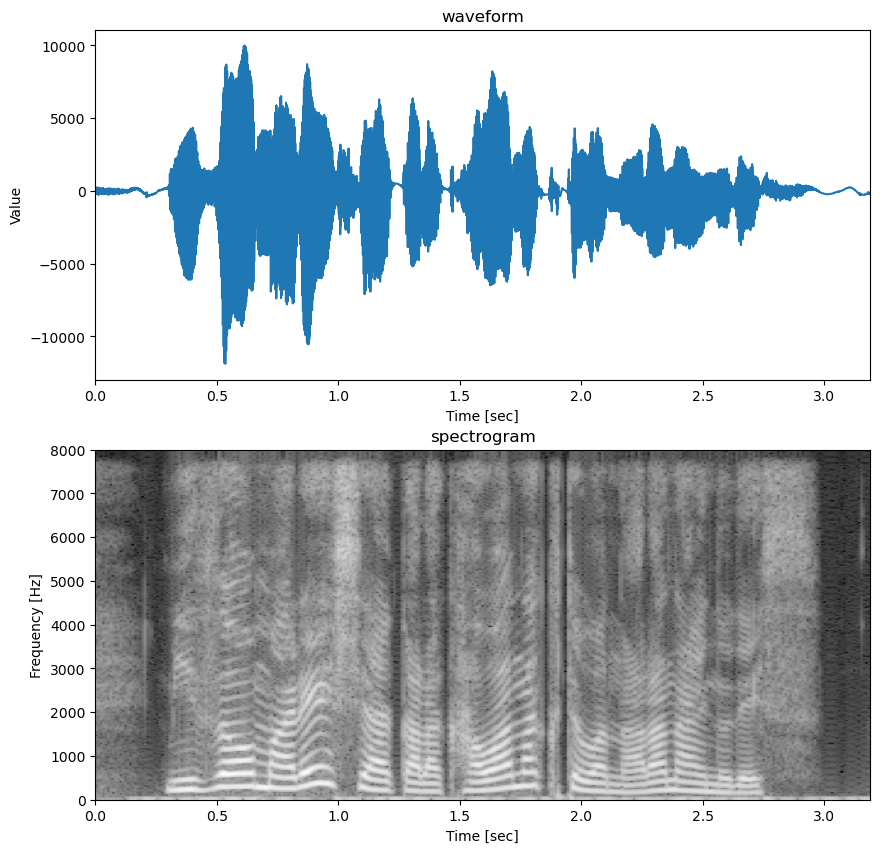

In [3]:
import wave
import numpy as np
import matplotlib.pyplot as plt

if __name__=="__main__":
    
    wav_file='./data/wav/BASIC5000_0001.wav'
    #음성인식에서 일반적으로 프레임 사이즈 20~30ms, 프레임 시프트는 10~20ms
    frame_size=25#프레임 사이즈 [milli sec=ms]
    frame_shift=10#프레임 시프트[milli sec=ms]
    out_plot='./spectrogram.png'
    
    with wave.open(wav_file) as wav:
        sample_frequency=wav.getframerate()
        num_samples=wav.getnframes()
        waveform=wav.readframes(num_samples)
        waveform=np.frombuffer(waveform, dtype=np.int16)
        
        frame_size=int(sample_frequency *frame_size *0.001)#16000Hz * 25ms *0.001=400
        #프레임 사이즈를 ms에서 샘플수로 변환
        frame_shift=int(sample_frequency * frame_shift *0.001)
        #프레임 shift를 ms에서 샘플수로 변환
        
        #fft를 적용할 범위의 샘플수를 프레임사이즈보다 큰 2제곱수로 설정
        fft_size=1
        while fft_size<frame_size:#fft는 512가 됨
            fft_size*=2
        
        #단시간 푸리에 변환을 했을 때의 총 프레임 수를 계산
        num_frames =(num_samples - frame_size) //frame_shift +1
        #스펙트로그램 행렬 준비
        spectrogram = np.zeros((num_frames, int(fft_size/2)+1))
        
        #프레임별 진폭 스펙트럼 계산
        for frame_idx in range(num_frames):
            #분석 시작위치는,프레임번호(0시작)*(프레임시프트)
            start_index=frame_idx *frame_shift
            #1프레임만큼 파형추출
            frame = waveform[start_index:start_index+frame_size].copy()
            #해밍 창함수 적용
            frame=frame * np.hamming(frame_size)
            #로그 진폭 스펙트럼 계산
            spectrum=np.fft.fft(frame, n=fft_size)#데이터 개수가 400인 프레임에 대해 데이터 개수가 512가 될 때까지 0을 더한후 fft시행
            absolute=np.abs(spectrum)
            absolute=absolute[:int(fft_size/2)+1]
            log_absolute=np.log(absolute+ 1E-7)
            #계산 결과를 스펙트로그램으로 저장
            spectrogram[frame_idx,:]= log_absolute
            
        plt.figure(figsize=(10,10))
        plt.subplot(2,1,1)
        
        time_axis=np.arange(num_samples)/sample_frequency
        plt.plot(time_axis,waveform)
        
        plt.title('waveform')
        plt.xlabel('Time [sec]')
        plt.ylabel('Value')
        plt.xlim([0, num_samples / sample_frequency])
        
        plt.subplot(2,1,2)
        #스펙트로그램의 최대치를 0에 맞추어 color map 범위 조정
        spectrogram-=np.max(spectrogram)
        vmax= np.abs(np.min(spectrogram)) *0.0
        vmin= -np.abs(np.min(spectrogram)) * 0.7
        #시각화
        plt.imshow(spectrogram.T[-1::-1,:],#그대로 시각화하면 y축이 시간, x축이 주파수가 되므로 상하 반전시킴
                      extent=[0, num_samples/sample_frequency,0, sample_frequency/2],
                      cmap='gray',
                      vmax=vmax,
                      vmin=vmin,
                      aspect='auto')
        plt.title('spectrogram')
        plt.xlabel('Time [sec]')
        plt.ylabel('Frequency [Hz]')
        plt.savefig(out_plot)